### IMPORT   

In [95]:
import os
import numpy as np
import torch
import torch.optim as optim
import cv2
from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt
import pydicom
from pydicom.pixel_data_handlers.util import apply_modality_lut, apply_voi_lut
from mpl_toolkits.mplot3d import Axes3D
import plotly.graph_objects as go
import plotly.io as pio
import scipy.ndimage
import SimpleITK as sitk

from monai.networks.nets import UNet
from monai.losses import DiceLoss
from monai.utils import first
from monai.data import decollate_batch
from monai.metrics import DiceMetric

#### 특정 Layer 출력하는 함수

In [84]:
def plot_dicom_layer(volume, voxel_size, mode, layer_index):
    """
    3D DICOM 볼륨의 특정 단면을 출력하는 함수.

    Args:
        volume (numpy.ndarray): 3D DICOM 볼륨 (height, rows, columns).
        voxel_size (tuple): 각 축의 voxel 크기 (x, y, z).
        mode (str): 'axial', 'coronal', 'sagittal' 중 하나.
        layer_index (int): 출력할 레이어의 인덱스.
    """
    if mode == 'sagittal':
        if not (0 <= layer_index < volume.shape[0]):
            raise ValueError(f"Invalid layer index for sagittal mode: {layer_index}")
        slice_data = volume[layer_index, :, :]
        aspect_ratio = voxel_size[1] / voxel_size[2]
    elif mode == 'axial':
        if not (0 <= layer_index < volume.shape[1]):
            raise ValueError(f"Invalid layer index for axial mode: {layer_index}")
        slice_data = scipy.ndimage.zoom(volume[:, layer_index, :], 
                                        (voxel_size[0] / voxel_size[1], 1), 
                                        order=1)
        aspect_ratio = voxel_size[0] / voxel_size[2]
        
    elif mode == 'coronal':
        if not (0 <= layer_index < volume.shape[2]):
            raise ValueError(f"Invalid layer index for axial mode: {layer_index}")
        slice_data = scipy.ndimage.zoom(volume[:, :, layer_index], 
                                        (voxel_size[0] / voxel_size[2], 1), 
                                        order=1)
        aspect_ratio = voxel_size[0] / voxel_size[1]
    else:
        raise ValueError(f"Unsupported mode: {mode}. Choose 'axial', 'coronal', or 'sagittal'.")
    print(aspect_ratio)
    plt.figure(figsize=(8, 8))
    plt.imshow(slice_data, cmap='gray', aspect=aspect_ratio)
    plt.title(f"{mode.capitalize()} View - Layer {layer_index}")
    plt.axis('off')
    plt.show()

# 사용 예시
# plot_dicom_layer(dicom_volume, voxel_size, mode='axial', layer_index=50)
# plot_dicom_layer(dicom_volume, voxel_size, mode='coronal', layer_index=100)
# plot_dicom_layer(dicom_volume, voxel_size, mode='sagittal', layer_index=75)


### 데이터 받아오기 - Sagittal View임에 유의

In [85]:
dicom_folder_path = 'Data/002_S_6007/2017-03-31/1. Accelerated_Sagittal_MPRAGE/I835740'
# 폴더 내 모든 DICOM 파일 읽기
dicom_files = []

for root, dirs, files in os.walk(dicom_folder_path):
    for file in files:
        if file.lower().endswith('.dcm'):  # 파일 확장자가 '.dcm'인지 확인
            file_path = os.path.join(root, file)
            try:
                dicom_file = pydicom.dcmread(file_path)  # DICOM 파일 읽기
                dicom_files.append(dicom_file)
                #print(f"Loaded: {file_path}")
            except Exception as e:
                print(f"Error loading {file_path}: {e}")

for dicom_file in dicom_files:
    print(dicom_file.ImagePositionPatient)

print(f"총 {len(dicom_files)}개의 DICOM 파일을 로드했습니다.")

[-78.264229319312, -156.28870773315, 142.96877581812]
[-77.064229336652, -156.28870773315, 142.96877581812]
[-19.464230168949, -156.28870773315, 142.96877581812]
[54.935768755999, -156.28870773315, 142.96877581812]
[-83.064229249954, -156.28870773315, 142.96877581812]
[-17.064230203629, -156.28870773315, 142.96877581812]
[68.135768565265, -156.28870773315, 142.96877581812]
[105.33576802774, -156.28870773315, 142.96877581812]
[30.93576910279, -156.28870773315, 142.96877581812]
[26.135769172148, -156.28870773315, 142.96877581812]
[50.135768825358, -156.28870773315, 142.96877581812]
[60.935768669302, -156.28870773315, 142.96877581812]
[-97.46422904188, -156.28870773315, 142.96877581812]
[99.335768114437, -156.28870773315, 142.96877581812]
[9.3357694149017, -156.28870773315, 142.96877581812]
[28.535769137469, -156.28870773315, 142.96877581812]
[58.535768703981, -156.28870773315, 142.96877581812]
[69.335768547925, -156.28870773315, 142.96877581812]
[-60.264229579405, -156.28870773315, 142.9

### 환경설정 적용

In [86]:
dicom_file = dicom_files[0]
try:
    bit_allocated = dicom_file.BitsAllocated
    bit_stored = dicom_file.BitsStored
    window_center = dicom_file.WindowCenter
    window_width = dicom_file.WindowWidth
    slice_thickness = dicom_file.SliceThickness
    patient_size = dicom_file.PatientSize
    patient_weight = dicom_file.PatientWeight
    position = dicom_file.ImagePositionPatient
    orientation = dicom_file.ImageOrientationPatient
    rows = dicom_file.Rows
    cols = dicom_file.Columns
    pixel_spacing = dicom_file.PixelSpacing

    print(f"Bits Allocated: {bit_allocated}")
    print(f"Bits Stored: {bit_stored}")
    print(f"Window Center: {window_center}")
    print(f"Window Width: {window_width}")
    print(f"Slice Thickness: {slice_thickness}")
    print(f"Patient Size: {patient_size}")
    print(f"Patient Weight: {patient_weight}")
    print(f"Image Position (Patient): {position}")
    print(f"Image Orientation (Patient): {orientation}")
    print(f"Rows: {rows}")
    print(f"Columns: {cols}")
    print(f"Pixel Spacing: {pixel_spacing}")

except AttributeError as e:
    print(f"Attribute missing: {e}")

# Allocated Bit 수에 따라서 데이터타입 결정tion
if bit_allocated==8:
    dtype=np.uint8
elif bit_allocated==16:
    dtype=np.uint16
elif bit_allocated==32:
    dtype=np.uint32
else:
    raise ValueError(f"Unsupported Bit Allocated:{bit_allocated}")
print(f'dtype={dtype}')

Bits Allocated: 16
Bits Stored: 12
Window Center: 260
Window Width: 508
Slice Thickness: 1.1999999284744
Patient Size: 1.7018034058333
Patient Weight: 66.2244944442
Image Position (Patient): [-78.264229319312, -156.28870773315, 142.96877581812]
Image Orientation (Patient): [0, 1, 0, 0, 0, -1]
Rows: 256
Columns: 240
Pixel Spacing: [1.0546875, 1.0546875]
dtype=<class 'numpy.uint16'>


In [87]:
dicom_files_sorted = sorted(
    dicom_files, 
    key=lambda x: float(x.ImagePositionPatient[0])
)
#------------------------------------------------------
pixel_arrays = []
for dicom_file in dicom_files_sorted:
    #String to Float 처리해주기 -> 안하니까 오류나네(Byte라서)
    pixel_array = np.frombuffer(dicom_file.PixelData, dtype=dtype).reshape((rows,cols))
    pixel_arrays.append(pixel_array)
dicom_volume = np.stack(pixel_arrays, axis=0)
#------------------------------------------------------ 

voxel_size = (
    float(slice_thickness),
    float(pixel_spacing[0]),
    float(pixel_spacing[1]),
)
print(f"3D Volume Shape: {dicom_volume.shape}")
print(f"Voxel Size: {voxel_size}")

3D Volume Shape: (176, 256, 240)
Voxel Size: (1.1999999284744, 1.0546875, 1.0546875)


1.1377777099609128


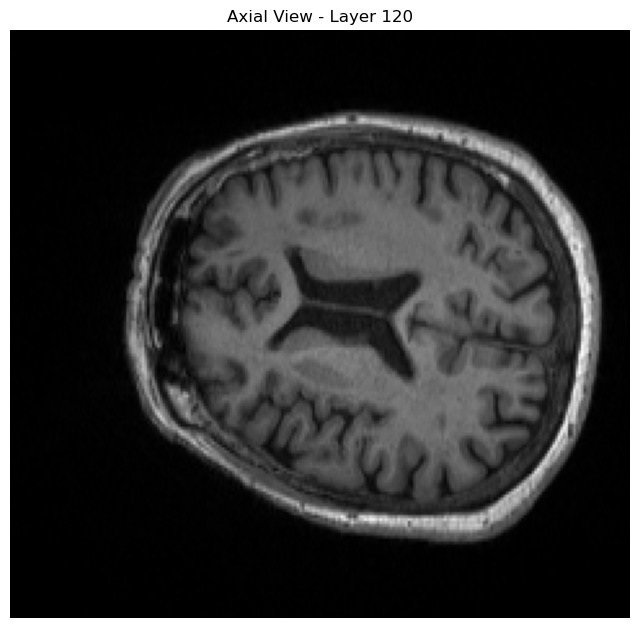

In [88]:
plot_dicom_layer(dicom_volume,voxel_size,mode='axial',layer_index=120)

### Segmentation------------------------------------------------------------------------------------------------------------------------------

In [89]:
sitk_image = sitk.GetImageFromArray(dicom_volume)
brain_mask = sitk.BinaryThreshold(sitk_image,lowerThreshold=500,upperThreshold=3000)
brain_mask = sitk.BinaryMorphologicalClosing(brain_mask,(5,5,5))
skull_stripped = sitk.Mask(sitk_image,brain_mask)
skull_stripped_array = sitk.GetArrayFromImage(skull_stripped)

1.1377777099609128


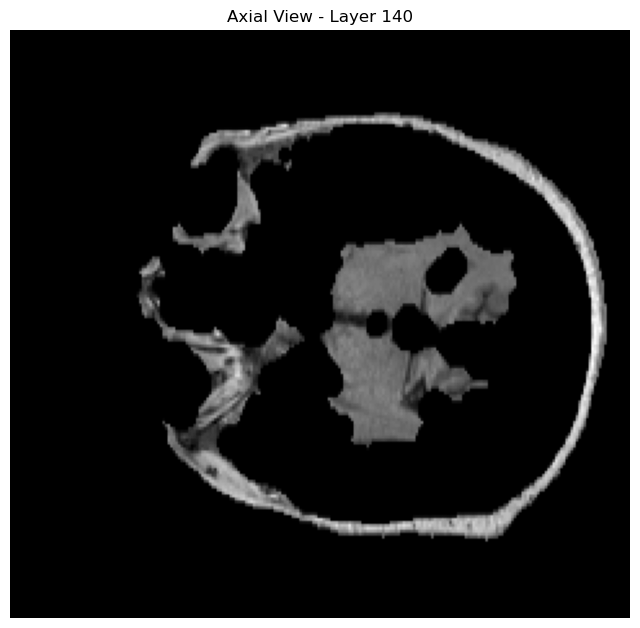

In [92]:
plot_dicom_layer(skull_stripped_array,voxel_size,mode='axial',layer_index=140)

### 여기서부터는 뭐지-----------------------------------------------------------------------------------------------------------------------------------------------------------------